In [165]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn import model_selection, preprocessing, metrics
import matplotlib.pyplot as plt
import glob
import re
import time
import seaborn as sns
import xgboost as xgb
import csv
import pickle
import scipy
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
color = sns.color_palette()

In [135]:
DATA_PATH = '/kaggle/dev/ashish/mnist-data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
SUBMISSION_PATH = '/kaggle/dev/ashish/mnist-data/submissions'
SAMPLE_SUBMISSION_PATH = os.path.join(DATA_PATH, 'sample_submission.csv')

In [109]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSION_PATH)
print('train_df.shape', train_df.shape)
print('test_df.shape', test_df.shape)
print('sample_submission_df.shape', sample_submission_df.shape)

train_df.shape (42000, 785)
test_df.shape (28000, 784)
sample_submission_df.shape (28000, 2)


In [110]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
sample_submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


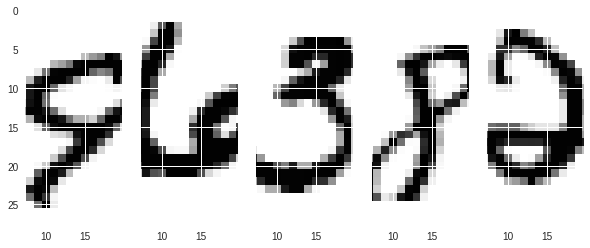

In [113]:
fig, axes = plt.subplots(1, 5, sharey='row', figsize=(10, 4))
plot_num = 0
# Plot sample images
for idx in list(np.random.randint(0, train_df.shape[0], 5)):
    axes[plot_num].imshow(train_df.iloc[idx].values[1:].reshape((28, 28)))
    plot_num += 1

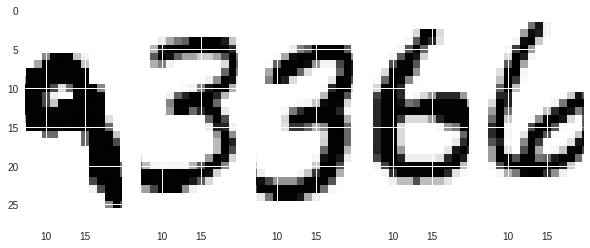

In [115]:
fig, axes = plt.subplots(1, 5, sharey='row', figsize=(10, 4))
plot_num = 0
# Plot sample images
for idx in list(np.random.randint(0, test_df.shape[0], 5)):
    axes[plot_num].imshow(test_df.iloc[idx].values.reshape((28, 28)))
    plot_num += 1

In [178]:
# model = Sequential()
# model.add(Dense(128, input_shape=(784,)))
# model.add(Activation('relu'))
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dense(10))
# model.add(Activation('softmax'))

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), 
                 strides=(1, 1), 
                 input_shape=(28, 28, 1), 
                 activation='relu', 
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), 
                 strides=(1, 1),
                 activation='relu',
                 padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 1024)              3212288   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
__________

In [180]:
data = train_df.values[:,1:].reshape(-1, 28, 28, 1)
labels = train_df.values[:,0]
labels_one_hot = np.eye(10)[labels]
model.fit(data, labels_one_hot, epochs=5, batch_size=64, validation_split=0.2, verbose=1)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 22s - loss: 0.0481 - acc: 0.9850 - val_loss: 0.0589 - val_acc: 0.9833
Epoch 2/5
33600/33600 [==============================] - 22s - loss: 0.0436 - acc: 0.9867 - val_loss: 0.0599 - val_acc: 0.9844
Epoch 3/5
33600/33600 [==============================] - 22s - loss: 0.0369 - acc: 0.9881 - val_loss: 0.0766 - val_acc: 0.9815
Epoch 4/5
33600/33600 [==============================] - 22s - loss: 0.0386 - acc: 0.9887 - val_loss: 0.0603 - val_acc: 0.9858
Epoch 5/5
33600/33600 [==============================] - 22s - loss: 0.0359 - acc: 0.9897 - val_loss: 0.0727 - val_acc: 0.9830


Model trained with 98% accuracy

In [181]:
data_test = test_df.values.reshape(-1, 28, 28, 1)
preds_test = model.predict(data_test)
preds_test_labels = np.argmax(preds_test, axis=1)
preds_test_labels.shape

(28000,)

In [182]:
sample_submission_df.Label = preds_test_labels

In [185]:
ts = int(time.time())
filename = "submission-{}.csv".format(ts)
filepath = os.path.join(SUBMISSION_PATH, filename)
sample_submission_df.to_csv(filepath, index=False)
print('Genereated file: ', filepath)

Genereated file:  /kaggle/dev/ashish/mnist-data/submissions/submission-1501700277.csv
